# Garbage

In [1]:
import os
import re
import numpy as np
import pandas as pd
import pylab as plt
from matplotlib.dates import DateFormatter
from functools import reduce

In [2]:
%matplotlib inline

## Set up

### Categories

In [3]:
category = ['C', 'R', 'V', 'G', 'Cd', 'Cat']
col = ['g', 'y', 'b', 'r', 'lightgreen', 'darkred']
lab = ['compost', 'recycling', 'glass', 'garbage', 'dry compost', 'cat']

color = {}
label = {}
for i in range(len(category)):
    color[category[i]] = col[i]
    label[category[i]] = lab[i]

## Read rst file

In [5]:
file_name = './garbage.rst'
with open(file_name, 'r', encoding="utf-8", errors='ignore') as file:
    lines = file.readlines()

In [6]:
cur_year = None
# List of years appearing in rst file
all_years = [2020, 2021]
year_arr = []

# Column names where 2nd trailing line is appended to previous line
cols_app_next_line = []

i = 0
for line in lines:
    
    line = line.strip()
    
    # Get current year = heading
    for year in all_years:
        if re.match('\A{}'.format(year), line):
            cur_year = year
            continue

    # Before first year heading: we are still in preamble
    if cur_year == None:
        continue

    # Table row deliminators
    if re.match('\A\+\-', line):
        continue

    dat = re.split(' *\|{1} *', line)[1:]
    if len(dat) == 0:
        continue
        
    if dat[0] == 'date':
        if cur_year == all_years[0]:
            header = dat
            print('Creating new pandas data frame')
            df = pd.DataFrame(columns=header)
    else:
        if len(dat[0]) == 0:
            for c in cols_app_next_line:
                idx = df.columns.get_loc(c)
                df.loc[i-1][c] = '{} {}'.format(df.loc[i-1][c], dat[idx])
        else:
            # Add new line
            df.loc[i] = dat
            i = i + 1

            year_arr.append(cur_year)
        
print('Entries from {}/{} to {}/{}'.format(df['date'][0], all_years[0],
                                           df['date'][len(df)-1], all_years[-1]))
print('Read {} lines into data frame'.format(i))

Creating new pandas data frame
Entries from 18/11/2020 to 20/03/2021
Read 116 lines into data frame


## Adding values

### Year

In [7]:
year_ser = pd.Series(year_arr)
df = df.assign(year=year_ser.values)

### Times in datetime format

In [8]:
tmp = df['date'] + '/' + df['year'].astype(str)
df['dmy'] = pd.to_datetime(tmp, format='%d/%m/%Y')

### Types as groups

In [9]:
groups = df.groupby('type')

### Transform columns

In [10]:
# Set date as index columns
df.set_index(['dmy'], inplace=True)

# Set weight to float
df['weight'] = pd.to_numeric(df['weight'])

## Plots

### Scatter plot of day versus weight

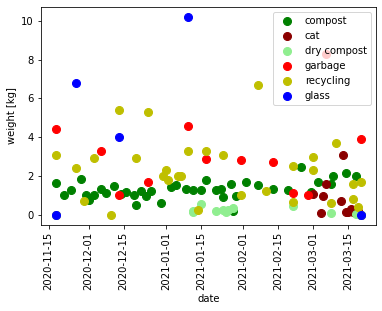

In [50]:
fig, ax = plt.subplots()

#from pandas.plotting import register_matplotlib_cdonverters
#register_matplotlib_converters()

for name, group in groups:
    ax.plot(group.index, group.weight, marker='o', color=color[name], linestyle='', ms=8, label=label[name])
ax.legend()
ti = plt.xticks(rotation='vertical')
xl = plt.xlabel('date')
yl = plt.ylabel('weight [kg]')
plt.savefig('all.png')

###  Summed weights per time interval

In [14]:
period = ['1M', '1W']
xlab = ['b', 'W']

summed_all = {}

for p in period:
    summed = []

    for name, group in groups:
        tmp = group.resample(p).sum()
        tmp.columns = [label[name], 'dummy']
        tmp[label[name]] = pd.to_numeric(tmp[label[name]])
        summed.append(tmp)
    summed_all[p] = reduce(lambda left,right: pd.merge(left,right,on='dmy'), summed)

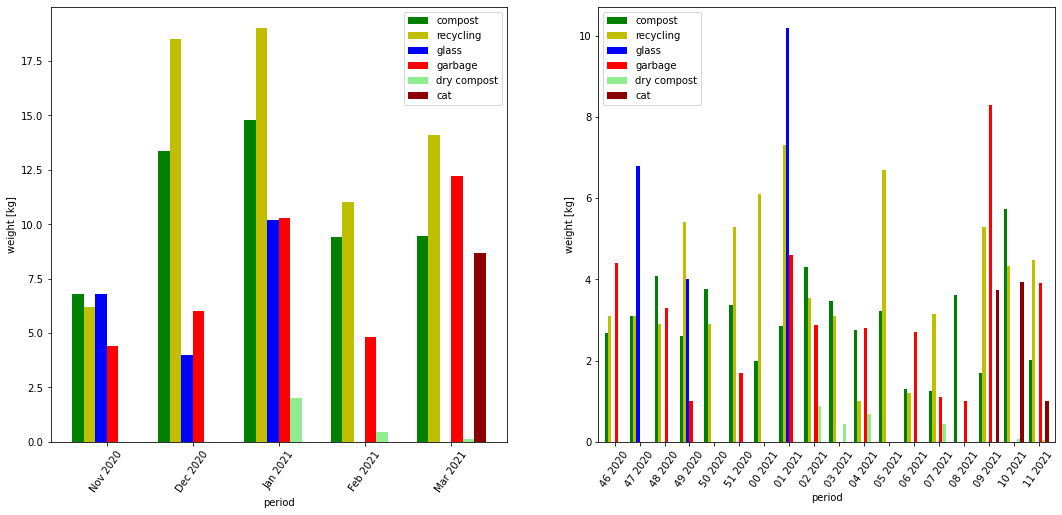

In [51]:
fig, ax_list = plt.subplots(ncols=len(period), figsize=(18, 8))

types = list(label.values())
colors = list(color.values())

for p, ax, xl in zip(period, ax_list, xlab):
    plot = summed_all[p].plot(ax=ax, kind='bar', y=types, color=colors, rot=55, width=0.8)
    ax.xaxis.set_major_formatter(plt.FixedFormatter(summed_all[p].index.to_series().dt.strftime('%{} %Y'.format(xl))))

    ax.set_xlabel('period')
    ax.set_ylabel('weight [kg]')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.savefig('summed.png')

### Total weights

In [18]:
x = []
y = []
col = []

for name, group in groups:
    x.append(label[name])
    y.append(group.weight.sum())
    col.append(color[name])

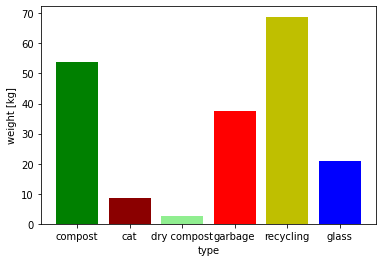

In [52]:
fig, ax = plt.subplots()

ax.bar(x, y, color=col)

ax.set_xlabel('type')
yl = ax.set_ylabel('weight [kg]')
plt.savefig('total.png')

In [48]:
pie = pd.DataFrame({'weight': y}, index=x)

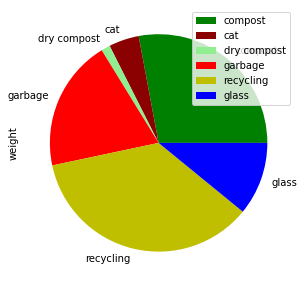

In [53]:
pie.plot.pie(y='weight', figsize=(5,5), colors=col)
plt.savefig('pie.png')